# Quick RL

This simulation compares the results between greedy decisions & RL decisions for a particular type of bandit algorithm.

**Thompson sampling** is the name given to the use of a beta-binomial statistical model to make binary classification decisions based on a one-dimensional input, namely the reward signal.

The **beta-binomial model** is an example of a Bayesian model, which uses probability distributions directly to make predictions about random events. In this case the binomial distribution is the one that matches our reward signal, so it becomes our **likelihood function**, and the beta is its **conjugate prior** (eg, they pair nicely).

The most important relationship is between the data and the likelihood function. The empirical **reward signal** is assumed to be binary (0/1), therefore each trial is a Bernoulli trial, and the success probability over many trials follows a binomial distribution by definition.

First up are some imports, followed by a few global variables that control the simulation.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

N_EPOCHS = 1000        # num simulation paths
N_STEPS = 1000         # num steps per path

PROBS = [0.01, 0.2, 0.8]    # win probabilities for 3-armed bandit
ARMS = range(len(PROBS))

RNG = np.random.default_rng()

The next two classes are 1-armed bandit models. Each bandit has an `update` method to update its estimate of the rewards distribution using a new (binary) observation, and a `predict` method to output a forecast of the success probability given the observed history of rewards.

The `GreedyBandit` class does this in a purely greedy fashion, making predictions that are always equal to the expected max of the rewards distribution.

The `ThompsonSampler` class uses an RL-style decision instead, making predictions that are sampled from the whole rewards distribution.

Note that `ThompsonSampler` uses **inheritance** to borrow characteristics from `GreedyBandit`.

In [2]:
class GreedyBandit(object):

    def __init__(self):
        self.a, self.b = 1, 1

    def update(self, reward):
        self.a += reward        # wins
        self.b += 1 - reward    # losses

    def predict(self):
        estimated_win_prob = self.a / (self.a + self.b)      # expected value of beta(a, b)
        return estimated_win_prob

class ThompsonBandit(GreedyBandit):

    def __init__(self):
        super().__init__()

    def predict(self):
        estimated_win_prob = RNG.beta(self.a, self.b)        # random draw from beta(a, b)
        return estimated_win_prob

Next is the `sim` function that simulates a path through the bandit's dynamic environment, solves the value & control problems, and outputs results.

The simulation introduces **non-stationarity** into the environment through a parameter `o`, and results are compared across values of `o` to measure the impact of non-stationarity on RL performance. This gives an approximation of real-world behavior, where the agent's environment is subject to unpredictable changes.

Note the critical practical implications of **partial information** on our implementation. The "true" full reward signal has as many dimensions as there are arms, but at each trial we observe only the (1d) reward corresponding to the chosen action.

In [3]:
def _bernoulli(p):
    return RNG.binomial(1, p)

def policy(preds):
    return np.argmax(preds)

def sim(e, dynamic_pct, policy_rewards_A, policy_rewards_B, shocks):

    probs = PROBS.copy()

    models_A = [GreedyBandit() for _ in ARMS]
    models_B = [ThompsonBandit() for _ in ARMS]

    actions_A, actions_B = list(), list()

    last_shock = 0, 0
    for k in range(N_STEPS):

        o = RNG.uniform()
        if o < dynamic_pct:

            _ = RNG.shuffle(probs)    # env shock

            shocks += 1
            last_shock = e, k, o

        all_rewards = [_bernoulli(p) for p in probs]     # Bernoulli rewards

        ### PREDICT ###

        predictions_A = [m.predict() for m in models_A]
        predictions_B = [m.predict() for m in models_B]

        action_A = policy(predictions_A)
        action_B = policy(predictions_B)

        _ = actions_A.append(action_A)
        _ = actions_B.append(action_B)

        ### EVAL ###

        rA, rB = all_rewards[action_A], all_rewards[action_B]       # rewards for chosen actions (partial info!)
        mA, mB = models_A[action_A], models_B[action_B]             # models for chosen actions

        policy_rewards_A += rA
        policy_rewards_B += rB

        ### UPDATE ###

        _ = mA.update(rA)
        _ = mB.update(rB)

        ### OUTPUT ###

        mod = 500
        if e % mod == k % mod == 0:

            print('\ne, k, dyn =', (e, k, dynamic_pct))
            print('probs =', probs)
            print('predictions_A =', [round(pA, 2) for pA in predictions_A])
            print('predictions_B =', [round(pB, 2) for pB in predictions_B])

            print('shocks =', shocks)
            print('last shock =', last_shock)

            print('all_rewards =', all_rewards)
            print('action_A, action_B =', (action_A, action_B))
            print('rA, rB =', (rA, rB))

            print('policy_rewards_A =', policy_rewards_A)
            print('policy_rewards_B =', policy_rewards_B)

            if k > 0:
                print('RL outperformance =', round(policy_rewards_B / policy_rewards_A, 2))

    return policy_rewards_A, policy_rewards_B, shocks

The remainder of the code runs the simulation across epochs for various levels of non-stationarity, and outputs results.

In [4]:
def run_over_epochs(dynamic_pct):

    policy_rewards_A, policy_rewards_B = 0, 0
    shocks = 0

    for e in range(N_EPOCHS):
        policy_rewards_A, policy_rewards_B, shocks = sim(e, dynamic_pct, policy_rewards_A, policy_rewards_B, shocks)

    return policy_rewards_B / policy_rewards_A - 1    # RL percent outperformance

In [5]:
results = dict()
for dynamic_pct in np.arange(0, 1, 0.1):
    results[dynamic_pct] = run_over_epochs(dynamic_pct)


e, k, dyn = (0, 0, 0.0)
probs = [0.01, 0.2, 0.8]
predictions_A = [0.5, 0.5, 0.5]
predictions_B = [0.22, 0.3, 0.09]
shocks = 0
last shock = (0, 0)
all_rewards = [0, 1, 0]
action_A, action_B = (0, 1)
rA, rB = (0, 1)
policy_rewards_A = 0
policy_rewards_B = 1

e, k, dyn = (0, 500, 0.0)
probs = [0.01, 0.2, 0.8]
predictions_A = [0.33, 0.33, 0.78]
predictions_B = [0.14, 0.32, 0.77]
shocks = 0
last shock = (0, 0)
all_rewards = [0, 0, 0]
action_A, action_B = (2, 2)
rA, rB = (0, 0)
policy_rewards_A = 391
policy_rewards_B = 388
RL outperformance = 0.99

e, k, dyn = (500, 0, 0.0)
probs = [0.01, 0.2, 0.8]
predictions_A = [0.5, 0.5, 0.5]
predictions_B = [0.02, 0.88, 0.83]
shocks = 0
last shock = (0, 0)
all_rewards = [0, 0, 0]
action_A, action_B = (0, 1)
rA, rB = (0, 0)
policy_rewards_A = 398113
policy_rewards_B = 396712

e, k, dyn = (500, 500, 0.0)
probs = [0.01, 0.2, 0.8]
predictions_A = [0.33, 0.33, 0.8]
predictions_B = [0.11, 0.2, 0.8]
shocks = 0
last shock = (0, 0)
all_rewards = [0, 0, 1]
actio


e, k, dyn = (0, 0, 0.7000000000000001)
probs = [0.01, 0.2, 0.8]
predictions_A = [0.5, 0.5, 0.5]
predictions_B = [0.94, 0.18, 0.35]
shocks = 0
last shock = (0, 0)
all_rewards = [0, 0, 1]
action_A, action_B = (0, 0)
rA, rB = (0, 0)
policy_rewards_A = 0
policy_rewards_B = 0

e, k, dyn = (0, 500, 0.7000000000000001)
probs = [0.8, 0.01, 0.2]
predictions_A = [0.25, 0.25, 0.38]
predictions_B = [0.39, 0.27, 0.42]
shocks = 359
last shock = (0, 500, 0.546920159904623)
all_rewards = [1, 0, 0]
action_A, action_B = (2, 2)
rA, rB = (0, 0)
policy_rewards_A = 186
policy_rewards_B = 190
RL outperformance = 1.02

e, k, dyn = (500, 0, 0.7000000000000001)
probs = [0.01, 0.8, 0.2]
predictions_A = [0.5, 0.5, 0.5]
predictions_B = [0.95, 0.7, 0.55]
shocks = 349534
last shock = (500, 0, 0.28707301589543965)
all_rewards = [0, 0, 0]
action_A, action_B = (0, 0)
rA, rB = (0, 0)
policy_rewards_A = 168887
policy_rewards_B = 169824

e, k, dyn = (500, 500, 0.7000000000000001)
probs = [0.8, 0.01, 0.2]
predictions_A = 

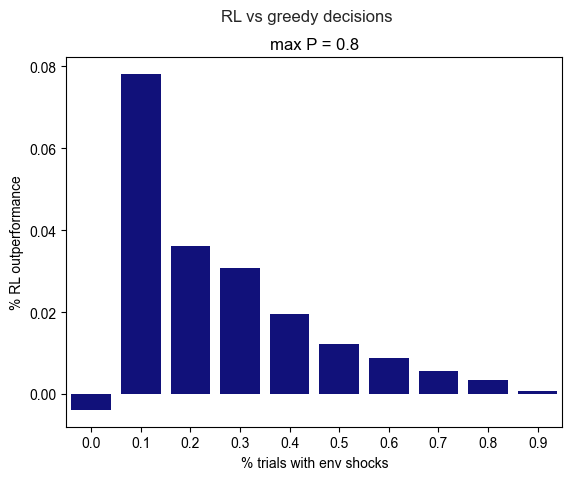




In [6]:
k = pd.DataFrame(pd.Series(results))
sns.barplot(k, x=np.array(k.index).round(2), y=k.values.ravel(), color='darkblue')
sns.set_style('darkgrid')

plt.suptitle('RL vs greedy decisions')
plt.title('max P = %s' % max(PROBS))

plt.ylabel('% RL outperformance')
plt.xlabel('% trials with env shocks')

plt.show()

The results show that exploration contributes to better performance in general, unless the environment is either perfectly stationary or perfectly non-stationary.

In a **perfectly stationary** environment, there is never an opportunity to make up for the cost of exploration, so RL always loses to a greedy strategy.

Exploration is most likely to pay off in an environment with **some non-stationarity**, with the benefits decreasing as the amount of signal in the data decreases.

For a **highly non-stationary** environment, the benefits of exploration decrease as the amount of usable signal decreases. With little information available through the reward signal, the strategy of uniform sampling becomes difficult to beat.